In [1]:
## This section aims to utilize a linear regression model to analyze running back performance. 
## We will utilize linear regression to add context into a running backs performance 



In [2]:
## EDA
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

seasons = range(2016, 2024 +1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


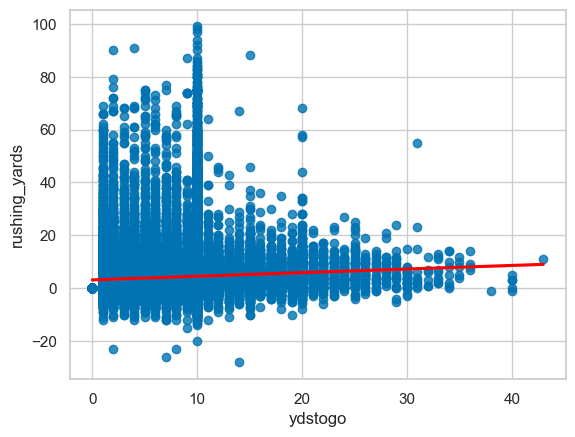

In [3]:
pbp_py_run =\
    pbp_py.query('play_type == "run" and rusher_id.notnull()')\
    .reset_index()

#replace null values with 0
pbp_py_run\
    .loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"]=0

##plot raw data to analyze before continuing
sns.set_theme(style = 'whitegrid', palette = 'colorblind')
sns.regplot(data = pbp_py_run, x = 'ydstogo', y = 'rushing_yards', line_kws={"color": "red"})
plt.show()

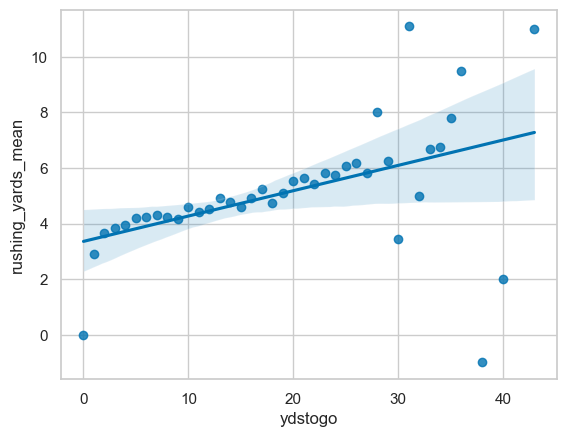

In [4]:
## try a binning approach to the data to see how that reveals anything in the relationship
pbp_py_run_ave = \
    pbp_py_run.groupby(['ydstogo'])\
    .agg({'rushing_yards': ['mean']})

pbp_py_run_ave.columns = \
    list(map('_'.join, pbp_py_run_ave.columns))
pbp_py_run_ave\
    .reset_index(inplace = True)

sns.regplot(data = pbp_py_run_ave, x = 'ydstogo', y = 'rushing_yards_mean')
plt.show()

In [5]:
## run an ordinary least squares regression to analyze prediction of rushing yards based on yards to go
yard_to_go_py =\
    smf.ols(formula = 'rushing_yards ~ 1 + ydstogo', data = pbp_py_run)

print(yard_to_go_py.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     828.2
Date:                Fri, 22 Nov 2024   Prob (F-statistic):          1.80e-181
Time:                        13:46:49   Log-Likelihood:            -3.7162e+05
No. Observations:              114383   AIC:                         7.432e+05
Df Residuals:                  114381   BIC:                         7.433e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1762      0.042     75.632      0.0

In [6]:
## save the residuals from the previous model by creating a RYOE column
pbp_py_run["ryoe"]=\
    yard_to_go_py\
    .fit()\
    .resid

## Who was the best in RYOE?

In [41]:
ryoe_py =\
    pbp_py_run\
    .groupby(['season', 'rusher_id', 'rusher'])\
    .agg({
        'ryoe': ['count', 'sum', 'mean'],
        'rushing_yards': 'mean'})

ryoe_py.columns =\
    list(map('_'.join, ryoe_py.columns ))
ryoe_py.reset_index(inplace= True)

ryoe_py = \
    ryoe_py\
        .rename(columns =  {
            'ryoe_count': 'n',
            'ryoe_sum': 'ryoe_total',
            'ryoe_mean': 'ryoe_per',
            'rushing_yards_mean': 'yards_per_carry'
            }
        ).query('n > 50')

print(ryoe_py.sort_values('ryoe_total', ascending = False).reset_index(drop = True).to_string())


     season   rusher_id             rusher    n  ryoe_total  ryoe_per  yards_per_carry
0      2021  00-0036223           J.Taylor  332  422.702084  1.273199         5.454819
1      2020  00-0032764            D.Henry  397  367.945569  0.926815         5.206549
2      2019  00-0034796          L.Jackson  135  355.829699  2.635776         6.800000
3      2024  00-0032764            D.Henry  197  349.315827  1.773177         6.015228
4      2023  00-0033280        C.McCaffrey  331  336.690446  1.017192         5.217523
5      2023  00-0039040           D.Achane  109  333.097202  3.055938         7.422019
6      2019  00-0032764            D.Henry  387  328.946816  0.849992         5.131783
7      2020  00-0033293            A.Jones  222  291.565325  1.313357         5.540541
8      2024  00-0034844          S.Barkley  199  286.772075  1.441066         5.713568
9      2019  00-0031687          R.Mostert  190  283.900544  1.494213         5.831579
10     2016  00-0033045          E.Elliott 

## Is RYOE a better (more stable) metric?

In [54]:
## keep only the columns needed
cols_keep =\
    ['season', 'rusher_id', 'rusher', 'ryoe_per', 'yards_per_carry']

## create new dataframe
ryoe_now_py=\
    ryoe_py[cols_keep].copy()

## create last years dataframe
ryoe_last_py =\
    ryoe_py[cols_keep].copy()

## rename columns
ryoe_last_py\
        .rename(columns = {'ryoe_per': 'ryoe_per_last',
                            'yards_per_carry': 'yards_per_carry_last'},
                               inplace = True)
    
## add 1 to season
ryoe_last_py['season'] += 1

#merge together
ryoe_lag_py =\
    ryoe_now_py\
    .merge(ryoe_last_py,
          how = 'inner',
          on = ['rusher_id', 'rusher', 'season'])

## examine correlation of the two metrics

yards_per_carry_correlation = ryoe_lag_py[['yards_per_carry_last', 'yards_per_carry']].corr()

ryoe_per_correlation = ryoe_lag_py[['ryoe_per_last', 'ryoe_per']].corr()

print(yards_per_carry_correlation)
print(ryoe_per_correlation)



                      yards_per_carry_last  yards_per_carry
yards_per_carry_last              1.000000         0.316653
yards_per_carry                   0.316653         1.000000
               ryoe_per_last  ryoe_per
ryoe_per_last       1.000000  0.336092
ryoe_per            0.336092  1.000000


In [ ]:
## based on correlation calculated above, RYOE is a more stable stat year to year